# Import the Data

In [1]:
!pip install scikit-image

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


In [2]:
import os
import numpy as np
import pandas as pd 
from PIL import Image 
from skimage.transform import resize
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split

In [4]:
# Load the images and some metadata  
train_img_dir = 'training_patches/'
test_img_dir = 'testing_patches/'
img_w, img_h, img_ch = 224, 224, 3
train_filenames = os.listdir(train_img_dir) # read in the names of the image files 
test_filenames = os.listdir(test_img_dir)
#filenames = [x.split('.')[0] for x in filenames] # remove the .jpg extensions for joining later 
train_img_files_df = pd.DataFrame(train_filenames, columns = ['filenames']) # create a pandas dataframe 
test_img_files_df = pd.DataFrame(test_filenames, columns = ['filenames']) # create a pandas dataframe 
print("Train data set size: %d \nTest data set size: %d" %(len(train_filenames), len(test_filenames)) )
train_img_files_df.head() # print the first few values to see if they look right


Train data set size: 1741 
Test data set size: 452


,filenames
0,010-1988-C1_6.jpg
1,010-1988-ACDS_5.jpg
2,009-1982-3_9.jpg
3,015-1991-7_3.jpg
4,004-1989-B2_9.jpg


In [8]:
# Load the labels 
labels_dir = 'binaryOutcomes.csv'
labels_df = pd.read_csv(labels_dir, usecols=['Individual Patch', 'Binary Outcome'])
labels_df['filenames'] = labels_df['Individual Patch'] + '.jpg'
labels_df.head() # print the first few to see if they look right

,Individual Patch,Binary Outcome,filenames
0,001-2002-1_1,0,001-2002-1_1.jpg
1,001-2002-1_2,0,001-2002-1_2.jpg
2,001-2002-1_3,0,001-2002-1_3.jpg
3,001-2002-1_4,0,001-2002-1_4.jpg
4,001-2002-1_5,0,001-2002-1_5.jpg


# Pre Process the Data

In [12]:
#combining train and test into one dataset
train_img_files_df['train/test'] = 'train'
test_img_files_df['train/test'] = 'test'

img_files_df = pd.DataFrame.append(train_img_files_df, test_img_files_df)
# let's make sure each data point has both a label and an image by taking the intersection of these data frames 

full_data_points = img_files_df.merge(labels_df, on='filenames')

# keep track of the total number of full data points 
num_imgs, _ = full_data_points.shape

In [14]:
# Iterate over all the images in the directory and place them in a numpy array 
# with their corresponding labels 
imgs = np.zeros((img_w, img_h, img_ch, num_imgs))
labels = np.zeros(num_imgs)
for i, img_file in enumerate(full_data_points['Individual Patch'].values): 
    
    # display progress
    if i % 100 == 0:
        print(i, 'out of', num_imgs, 'images processed')
        
    # read in the image     
    img = np.asarray(Image.open(train_img_dir + img_file + '.jpg'))
    
    # run pre-processing 
    imgs[:,:,:,i] = resize(img, (img_w, img_h, img_ch)) 
    
    labels[i] = full_data_points['Binary Outcome'].iloc[i] 
    

0 out of 1727 images processed
100 out of 1727 images processed
200 out of 1727 images processed
300 out of 1727 images processed
400 out of 1727 images processed
500 out of 1727 images processed
600 out of 1727 images processed
700 out of 1727 images processed
800 out of 1727 images processed
900 out of 1727 images processed
1000 out of 1727 images processed
1100 out of 1727 images processed
1200 out of 1727 images processed
1300 out of 1727 images processed
1400 out of 1727 images processed
1500 out of 1727 images processed
1600 out of 1727 images processed
1700 out of 1727 images processed


# Explore the Data

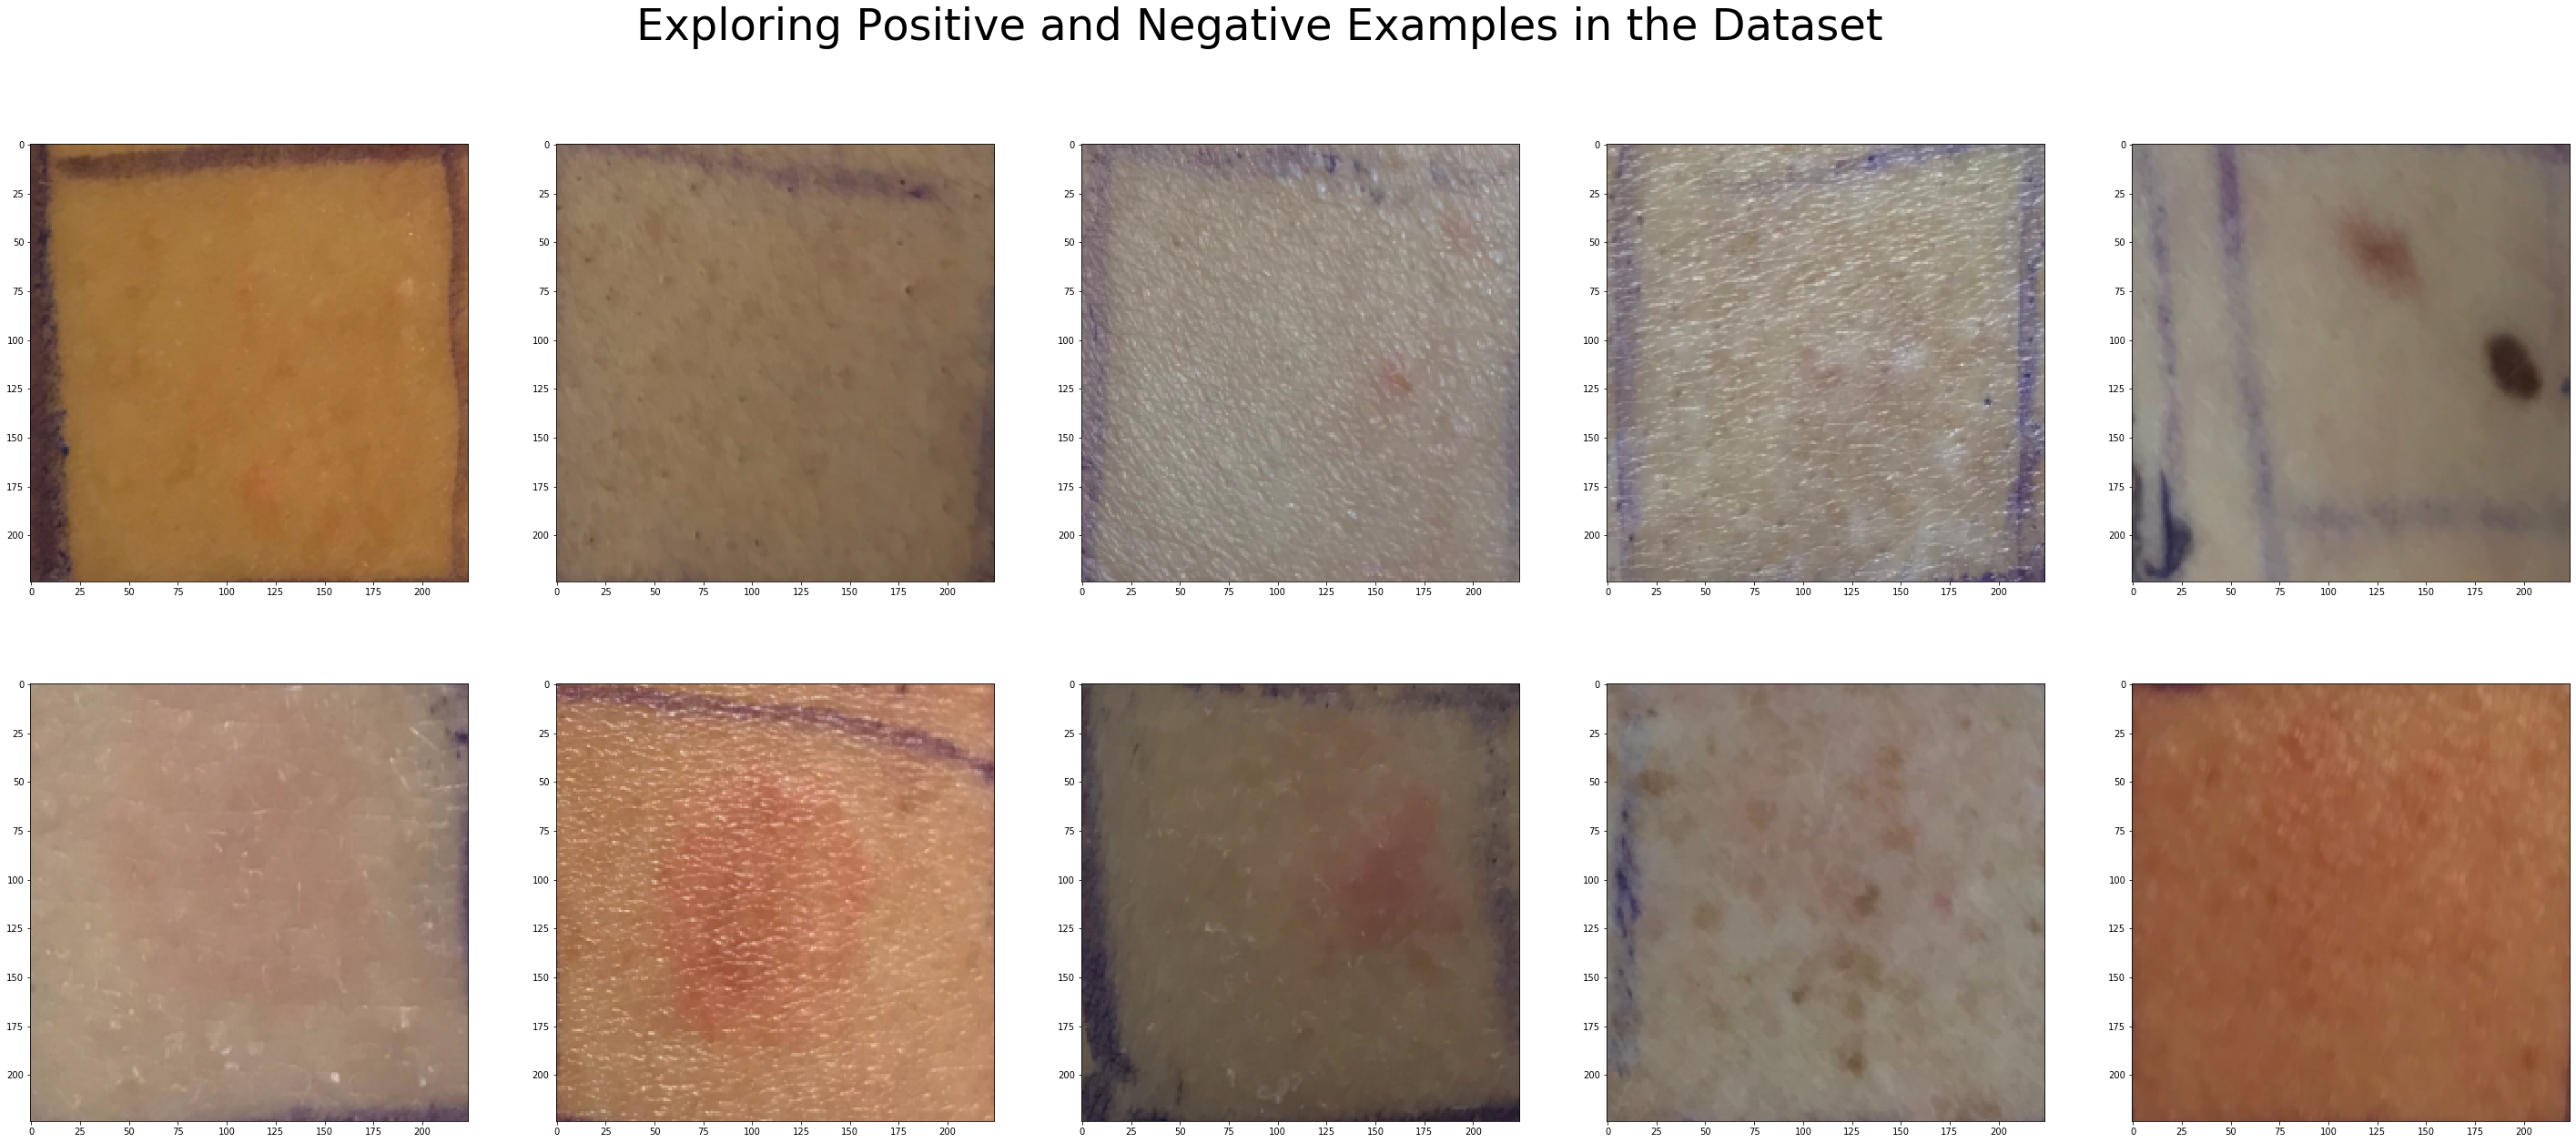

In [15]:
# Let's look at some positive and negative examples 

num_examples = 5
num_classes = 2

negative_indices = np.where(labels == 0)[0]
positive_indices = np.where(labels == 1)[0]

# randomly pick a subset from all of the examples 
negative_example_indices = np.random.choice(negative_indices, num_examples, replace=False)
positive_example_indices = np.random.choice(positive_indices, num_examples, replace=False)

plt.figure(figsize=(50, 20))
plt.suptitle('Exploring Positive and Negative Examples in the Dataset', fontsize=48)

# top row is negative examples 
for i, idx in enumerate(negative_example_indices): 
    plt.subplot(num_classes, num_examples, i+1)    
    plt.imshow(imgs[:,:,:,idx])

# bottom row is positive examples 
for i, idx in enumerate(positive_example_indices): 
    plt.subplot(num_classes, num_examples, i+num_examples+1)    
    plt.imshow(imgs[:,:,:,idx])

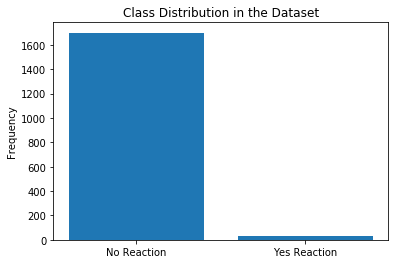

There are 1699 negative examples and 28 positive examples in the data set


In [16]:
# Let's look at the distribution of classes present in the data set 

num_positive = len(positive_indices)
num_negative = len(negative_indices)

classes = ['No Reaction', 'Yes Reaction']
y_pos = np.arange(len(classes))
performance = [num_negative, num_positive]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, classes)
plt.ylabel('Frequency')
plt.title('Class Distribution in the Dataset')

plt.show()

print('There are', int(num_negative), 'negative examples and', int(num_positive), 'positive examples in the data set' )

Because of the huge class imbalance, we are going to approach this as an anolamy detection task 

# Run Data Augmentations

In [18]:
# Perform data augmentations to increase the size of the dataset 
flip_ud = np.flip(imgs, 0) # flip the image up-down
flip_lr = np.flip(imgs, 1) # flip the image left-right
rot90 = np.rot90(imgs, 1) # rotate the image 90 degrees 
rot180 = np.rot90(imgs, 2) # rotate the image 180 degrees 
rot270 = np.rot90(imgs, 3)

In [19]:
# Put them all together in one matrix 
#aug_imgs = np.concatenate((imgs, flip_ud, flip_lr, rot90, rot180, rot270), axis=3)
aug_imgs = np.concatenate((flip_ud, flip_lr),axis = 3)
aug_labels = np.tile(labels, 2) 

# Verify the shape of the resulting matrix 
print(aug_imgs.shape)
print(aug_labels.shape)

(224, 224, 3, 3454)
(3454,)


In [17]:
# save images and labels arrays so we don't have to recompute each time
# np.save('imgs_np_array.npy', aug_imgs)
# np.save('labels_np_array.npy', aug_labels)

# load images and labels arrays 
# aug_imgs = np.load('imgs_np_array.npy')
# aug_labels = np.load('labels_np_array.npy') 

# Split the data into training, validation, and test sets

### We only need to train the autoencoder on negative samples
Let's use 70% of the negative examples to train the model, 10% to find the threshold, and 20% to test on 

In [20]:
negative_indices = np.where(aug_labels == 0)[0]
neg_train, neg_test = train_test_split(np.rollaxis(aug_imgs[:,:,:,negative_indices], 3), test_size=0.30) 
neg_test, neg_val = train_test_split(neg_test, test_size=0.33) 

# let's double check the shape of everything 
print(neg_train.shape, neg_val.shape, neg_test.shape)

(2378, 224, 224, 3) (337, 224, 224, 3) (683, 224, 224, 3)


Here let's use 70% of the positive samples to validate a threshold, and the other 30% to test 

In [21]:
positive_indices = np.where(aug_labels == 1)[0]
pos_val, pos_test = train_test_split(np.rollaxis(aug_imgs[:,:,:,positive_indices], 3), test_size=0.30) 

# let's double check the shape of everything 
print(pos_val.shape, pos_test.shape)

(39, 224, 224, 3) (17, 224, 224, 3)


# Build the model

We will create a simple autoencoder to run anomaly detection. 

In [22]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras import backend as K

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

In [23]:
# original (verified)
input_img = Input(shape=(224, 224, 3))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 8)         584       
_________________________________________________________________
max_

# Train the model

In [24]:
# since we will be testing many models, let's create a function to train, evaluate, and save statistics about each model 
# my_model: the keras model to train
def train_model(my_model, x_train, y_train, x_val, y_val): 
    
    # compile the model
    my_model.compile(loss='mean_squared_error',
        optimizer=optimizers.Adam(),
        metrics=['acc'])
    
    # create keras callbacks 
    es = EarlyStopping(monitor='val_loss', patience=1) 
    
    # train the model
    history = my_model.fit(
        x_train,
        y_train, 
        validation_data=(x_val,y_val), 
        batch_size=32, 
        epochs=10, 
        callbacks=[es] 
    )
    
    # save training statistics 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    
    plt.figure()

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(my_model.name + '_accuracy.png') 
    
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(my_model.name + '_loss.png') 
    
    # Save the model
    my_model.save(my_model.name + '.h5')
    
    return my_model

Instructions for updating:
Use tf.cast instead.
Train on 2378 samples, validate on 337 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2378/2378 [==============================] - 89s 37ms/sample - loss: 0.0099 - acc: 0.9095 - val_loss: 0.0080 - val_acc: 0.9123
Epoch 2/10
2378/2378 [==============================] - 81s 34ms/sample - loss: 0.0037 - acc: 0.9108 - val_loss: 0.0014 - val_acc: 0.9192
Epoch 3/10
2378/2378 [==============================] - 82s 35ms/sample - loss: 0.0013 - acc: 0.9107 - val_loss: 0.0011 - val_acc: 0.9184
Epoch 4/10
2378/2378 [==============================] - 72s 30ms/sample - loss: 0.0011 - acc: 0.9182 - val_loss: 9.5194e-04 - val_acc: 0.9280
Epoch 5/10
2378/2378 [==============================] - 79s 33ms/sample - loss: 9.1744e-04 - acc: 0.9281 - val_loss: 8.0072e-04 - val_acc: 0.9406
Epoch 6/10
2378/2378 [==============================] - 75s 32ms/sample - loss: 7.9424e-04 - acc: 0.9398 - val_loss: 7.3853e-04 - val_acc: 0.9472
Epoch 7/1

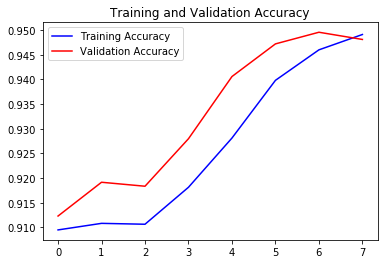

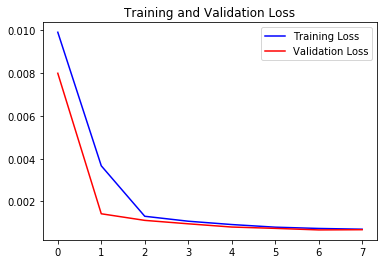

In [25]:
trained_model = train_model(autoencoder, neg_train, neg_train, neg_val, neg_val)  

# Calibrate the threshold

In [28]:
# --- SOME UTILITY FUNCTIONS --- 

# function to calculate the mse for each image
# input: an array of images and array of corresponding reconstructions 
# returns: an array of mse values
def get_mse_array(original, reconstruction): 
    num_imgs = original.shape[0]
    mse_array = np.zeros(num_imgs)
    
    for i in range(num_imgs): 
        mse_array[i] = (np.square(original[i,:,:,:] - reconstruction[i,:,:,:])).mean()
    
    return mse_array

# runs the data through the model and returns an array of the raw mse values 
def get_raw_predictions(model, data): 
    reconstruction = model.predict(data) 
    return get_mse_array(data, reconstruction)

# takes the raw prediction values and binarizes them based on the threshold 
def classify(raw_predictions, threshold):
    binary_predictions = np.zeros(raw_predictions.shape)
    for i in range(len(raw_predictions)):
        if raw_predictions[i] < threshold: 
            binary_predictions[i] = 0 
        else: 
            binary_predictions[i] = 1 
    return binary_predictions

In [29]:
neg_val_mse = get_raw_predictions(trained_model, neg_val)
pos_val_mse = get_raw_predictions(trained_model, pos_val)

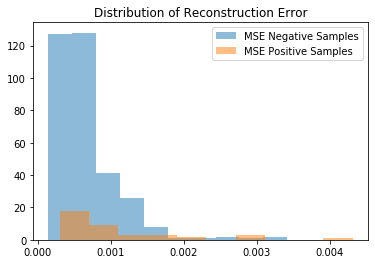

In [30]:
plt.title('Distribution of Reconstruction Error')
plt.hist(neg_val_mse, alpha=0.5, label='MSE Negative Samples')
plt.hist(pos_val_mse, alpha=0.5, label='MSE Positive Samples')
plt.legend(loc='upper right')
plt.show()

In [31]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.19')

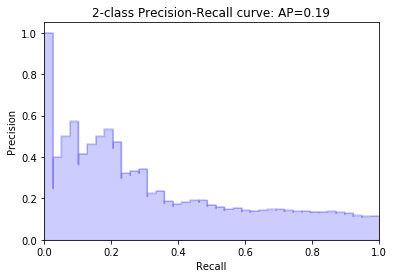

In [32]:
# combine all the positive and negative predictions (and labels) into one array
raw_y_pred = np.concatenate((neg_val_mse, pos_val_mse))
binary_y_true = np.concatenate((np.zeros(neg_val_mse.shape), np.ones(pos_val_mse.shape)))

# calculate precision-recall curve 
precision, recall, thresholds = precision_recall_curve(binary_y_true, raw_y_pred) 

# plot the curve 

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(np.mean(precision)))

In [33]:
# find threshold that yields a recall of 75% 
# since the recalls are listed in descending order, we will take the last one
# since the tpr will go up to 100, we just pick the first one that is above 75 
threshold_idx = np.where(recall > 0.75)[0][-1]
threshold = thresholds[threshold_idx]
print(threshold)

0.0005115878466348085


Now that we have determined a threshold based on our validation data, we can test our full model pipeline on the test data 

# Test the model on the test data set

In [34]:
# run the data through the autoencoder and calculate the mse for each data point 
neg_test_mse = get_raw_predictions(trained_model, neg_test)
pos_test_mse = get_raw_predictions(trained_model, pos_test)

In [35]:
# binarize those labels based on our threshold 
raw_y_pred = np.concatenate((neg_test_mse, pos_test_mse))
binary_y_pred = classify(raw_y_pred, threshold)
binary_y_true = np.concatenate((np.zeros(neg_test_mse.shape), np.ones(pos_test_mse.shape)))

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# This function comes from a scikit example found here: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

    np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[295 388]
 [  3  14]]


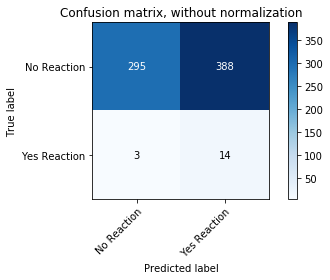

In [37]:
# calculate the confusion matrix 
plot_confusion_matrix(binary_y_true, binary_y_pred, classes=['No Reaction', 'Yes Reaction']) 